In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from scipy.spatial.distance import cdist
import scipy.stats
import copy
import math
from scipy.integrate import quad
from sklearn.cluster import KMeans

### Question 1  
**Write a program to implement a region segmentation algorithm using the fuzzy c-means algorithm on normalized 'RGBxy' data of an image. Merge stray (isolated) pixels (or very-smallregions) to their surrounding regions. [3 marks]**


In [2]:
img = cv2.imread("house21.jpg")
img = Image.open("house21.jpg")

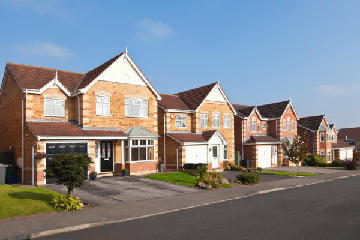

In [3]:
width, height = img.size 
newsize = (int(width*0.6), int(height*0.6))
img = img.resize(newsize)
display(img)

In [4]:
img = np.array(img)
img_data = np.zeros((img.shape[0], img.shape[1], 5))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img_data[i,j,0:3] = img[i,j]/255
        img_data[i,j,3] = i/img.shape[0]
        img_data[i,j,4] =  j/img.shape[1]
img_data = img_data.reshape(((img.shape[0]*img.shape[1], 5))).T
print(img_data.shape)

(5, 86400)


In [5]:
fcm = fuzz.cluster.cmeans(img_data, 25, 2, error=0.05, maxiter=1000, init=None)

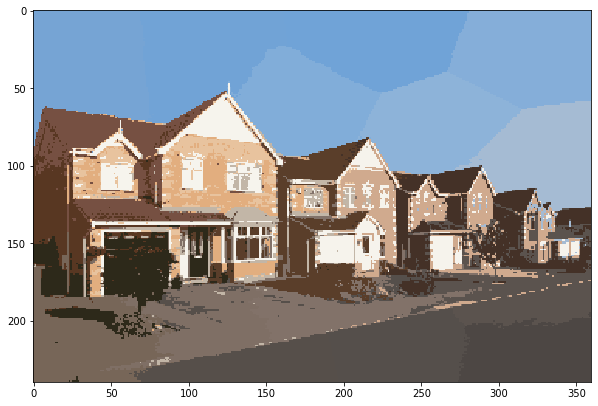

In [6]:
cluster_centers = fcm[0]
prob_matrix = fcm[1]
pred_matrix = np.argmax(prob_matrix, axis = 0)
pred_matrix = cluster_centers[pred_matrix]
clustered_image = pred_matrix[:,0:3]
clustered_image = clustered_image.reshape(((img.shape[0],img.shape[1], 3)))*255
clustered_image = clustered_image.astype(int)
plt.figure(figsize = (10,10))
plt.imshow(clustered_image)

### Question 2
**Write a program to obtain the spatial and contrast cues using SLIC superpixels of an image instead of pixels. [3 marks]**

(470, 870, 3)


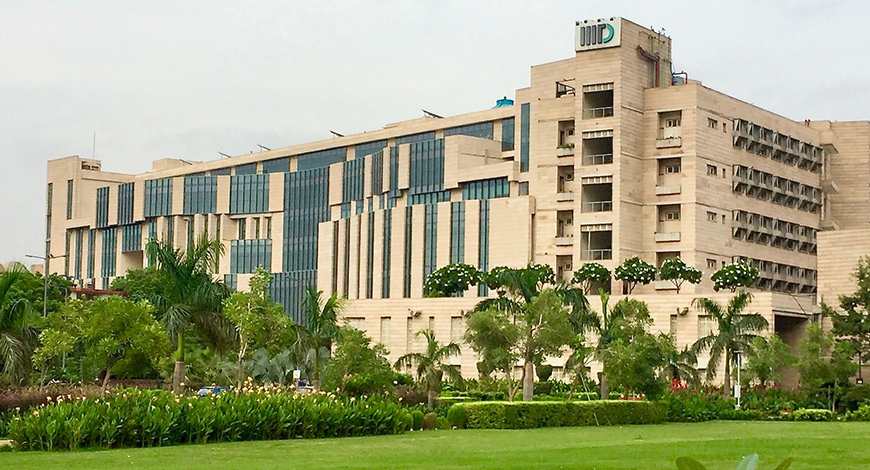

In [7]:
img_path = '1558014721_E7jyWs_iiit_d.jpg'
image  = cv2.imread(img_path)
# plt.imshow(image)
print(image.shape)
display(Image.open(img_path))

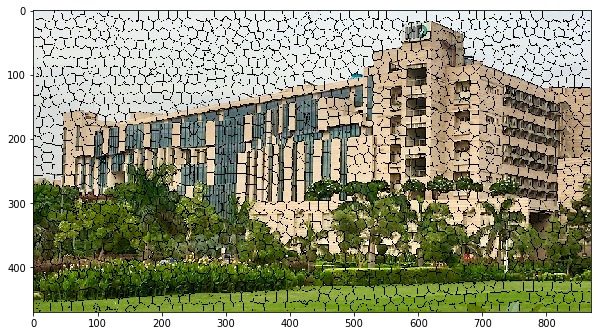

In [8]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Initialize the slic item, the average size of super pixels is 20 (default is 10), and the smoothing factor is 20
slic = cv2.ximgproc.createSuperpixelSLIC(img,region_size=15,ruler = 20.0) 
slic.iterate(40)     #Number of iterations, the greater the better
mask_slic = slic.getLabelContourMask() #Get Mask, Super pixel edge Mask==1
label_slic = slic.getLabels()        #Get superpixel tags
number_slic = slic.getNumberOfSuperpixels()  #Get the number of super pixels
mask_inv_slic = cv2.bitwise_not(mask_slic)  
img_slic = cv2.bitwise_and(img,img,mask =  mask_inv_slic) #Draw the superpixel boundary on the original image
plt.figure(figsize = (10,10))
plt.imshow(img_slic)


In [9]:
label_slic

array([[1322, 1322, 1322, ...,   57,   57,   57],
       [1322, 1322, 1322, ...,   57,   57,   57],
       [1322, 1322, 1322, ...,   57,   57,   57],
       ...,
       [1740, 1740, 1740, ..., 1797, 1797, 1797],
       [1740, 1740, 1740, ..., 1797, 1797, 1797],
       [1740, 1740, 1740, ..., 1797, 1797, 1797]], dtype=int32)

In [10]:
def get_super_image(image, segments):
    
    m,n = segments.shape
    
    dict_ = {}
    centers = {}

    for i in range(m):
        for j in range(n):
            if(segments[i,j] not in dict_):
                dict_[segments[i,j]] = []
                centers[segments[i,j]] = []
                dict_[segments[i,j]].append(image[i,j])
                centers[segments[i,j]].append(np.array([i,j]))
            else :
                dict_[segments[i,j]].append(image[i,j])
                centers[segments[i,j]].append(np.array([i,j]))
    for key in list(dict_.keys()):
        dict_[key] = np.mean(np.array(dict_[key]), 0).astype(int)
        centers[key] = np.mean(np.array(centers[key]), 0).astype(int)
            
    slic_image = np.zeros((image.shape[0],image.shape[1],3))
    
    for i in range(m):
        for j in range(n):
            slic_image[i,j] =  dict_[segments[i,j]]
    slic_image = slic_image.astype(int)
    
#     print(slic_image)
    plt.figure(figsize = (10,10))
    plt.imshow(slic_image)
    plt.title("SLIC Image")
    
    return slic_image, dict_, centers

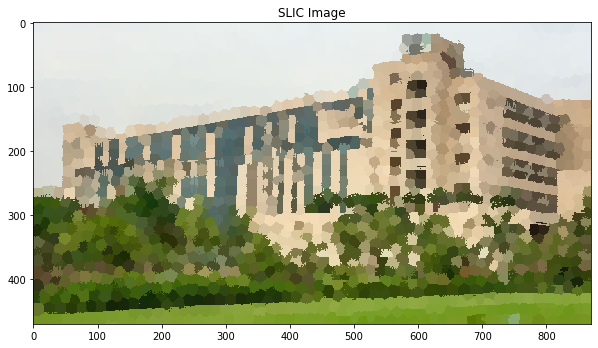

In [11]:
slic_image, dict_pixels, dict_centers = get_super_image(img,label_slic)

### Contrast Cue
Contrast cue represents the **visual feature uniqueness** on the single or multiple images. Contrast is one of the most widely used cues for measuring saliency in single image saliency detection algorithms, since the contrast operator simulates the human visual receptive fields. This rule is also valid in the case of cluster-based method for the multiple images, while the difference is that contrast cue on the cluster-level better represents the global correspondence relationship than the pixel/patch level. <br>
The contrast cue $w^c(k)$ of cluster $C^k$ is defined using its
feature contrast to all other clusters:

$$ w^c(k) = \sum_{i = 1, i\neq k}^{K}(\frac{n^i}{N}|| \nu^k - \mu^i||_2)$$
where a L2 norm is used to compute the distance on the feature space, $n^i$ represents the pixel number of cluster $C^i$
, and N denotes the pixel number of all images.

### Spatial Cue

In human visual system, the regions near the image center draw more attention than the other regions. When the distance between the object and the image center increases, the attention gain is depreciating. This scenario is known as **‘central bias rule’** in single image saliency detection. We extend this concept to the cluster-based method, which measures a global spatial distribution of the cluster.<br>
The spatial cue $w^s(k)$ of cluster $C^k$ is defined as:
$$ w^s(k) = \frac{1}{n^k}\sum_{j = 1}^{M}\sum_{i = 1}^{N_j} [N(|| z_i^k - o^j||^2| 0, \sigma^2).\delta(b(p_i^j) - C^k )]$$

where $\delta(.)$ is the Kronecker delta function, $o^j$ denotes the center of image $I^j$, and Gaussian kernel N (·) computes the Euclidean distance between pixel $z_i^j$ and the image center $o^j$, the variance $\sigma^2$ is the normalized radius of images. And the normalization coefficient $n^k$ is the pixel number of cluster $C^k$ . Different from the single image model, our spatial cue $w^s$ represents the location prior on the cluster-level, which is a global central bias on the multiple images.

The same as the contrast cue, the spatial cue is also **valid on both single and multiple images**.


In [12]:
def contrast_spatial_cue(slic_image, dict_pixels, label_slic, dict_centers):
    m,n = label_slic.shape
    
    data = np.zeros((len(list(dict_pixels.keys())), 3))
    l = sorted(list(dict_pixels.keys()))
    for i in range(len(l)):
        data[i] = dict_pixels[l[i]]
    
    data = np.float32(data)/255
    
    s_scores = []
    k = 5
    s_max = 0
    for k_i in tqdm(range(10,61), position = 0, desc = "Finding best k"):
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.2)
        _, labels, (centers) = cv2.kmeans(data, k_i, None, criteria, 200, cv2.KMEANS_RANDOM_CENTERS )
        ss = silhouette_score(data, np.squeeze(labels))
        s_scores.append(ss)
        if(ss > s_max):
            s_max = ss
            k = k_i
        
    plt.plot([i for i in range(10,61)], s_scores)
    plt.xlabel("Value of k")
    plt.ylabel("silhouette score")
    plt.show()
    
    print("\033[1mBest Value of k obtained is : \033[0m",k)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.02)
    _, labels, (centers) = cv2.kmeans(data, k, None, criteria, 200, cv2.KMEANS_RANDOM_CENTERS )
    pred_matrix = np.squeeze(labels)
    cluster_dist = cdist(centers,centers, 'euclidean')
    clustered_img = pred_matrix[label_slic]

    n_i = {}
    for i in np.unique(clustered_img):
        n_i[i] = np.count_nonzero(clustered_img == i)
    print("\033[1mNumber of Image Pixels per cluster : \033[0m",n_i)
    
    contrast_cues = {}
    for i in range(k):
        val = 0
        for j in range(k):
            if(i!=j):
                val+=(n_i[j]/(clustered_img.shape[0]*clustered_img.shape[1]))*cluster_dist[i,j]
        contrast_cues[i] = val
    print("\033[1mContrast Cues : \033[0m",contrast_cues)
    
    
    center_data = np.zeros((len(list(dict_centers.keys())), 2))
    l = sorted(list(dict_centers.keys()))
    for i in range(len(l)):
        a,b = dict_centers[l[i]]
        center_data[i,0] = a
        center_data[i,1] = b
    slic_image_center = dict_centers[label_slic[m//2,n//2]].reshape((1,2))
    slic_image_center[0,0] = slic_image_center[0,0]
    slic_image_center[0,1] = slic_image_center[0,1]
    slic_center_dist = cdist(center_data,slic_image_center,'euclidean')
    slic_center_dist_var = np.std(slic_center_dist)
    
    spatail_cues = {}
    for c in range(k):
        val = 0
        for i in range(len(slic_center_dist)):
            if(pred_matrix[i] == c):
                val+=scipy.stats.norm(0, slic_center_dist_var).pdf(slic_center_dist[i,0])
        val = val/np.count_nonzero(pred_matrix == c)
        spatail_cues[c] = val
    
                
    print("\033[1mSpatial Cues : \033[0m",spatail_cues) 
    
    final_image = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            idx = clustered_img[i,j]
            val = spatail_cues[idx]*contrast_cues[idx]
            
            final_image[i,j] = val
    plt.figure(figsize = (8,8))
    plt.imshow(final_image, cmap = 'gray')
    plt.title("Contrast and Spatial Cues of SLIC Image")
    return contrast_cues, spatail_cues,clustered_img, final_image
      
    
    

Finding best k: 100%|██████████████████████████████████████████████████████████████████| 51/51 [00:18<00:00,  2.78it/s]


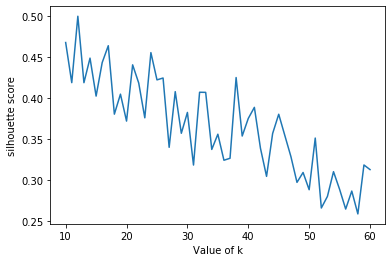

Best Value of k obtained is :  12
Number of Image Pixels per cluster :  {0: 30850, 1: 18227, 2: 53983, 3: 31794, 4: 40286, 5: 23412, 6: 17714, 7: 25440, 8: 13962, 9: 23613, 10: 25970, 11: 103649}
Contrast Cues :  {0: 0.5001077553295481, 1: 0.5745287569404574, 2: 0.4952804724575096, 3: 0.6359333665869334, 4: 0.4431685246076661, 5: 0.5724946495057592, 6: 0.5130627406302538, 7: 0.737204830960124, 8: 0.46519157909491693, 9: 0.4373689002792746, 10: 0.4947235316349006, 11: 0.6011630977697624}
Spatial Cues :  {0: 0.0001858025539258633, 1: 0.00046039491373016964, 2: 0.0014792389031498127, 3: 0.0005066217487978924, 4: 0.00046611763317128694, 5: 0.00046691656879523156, 6: 0.001820281254824394, 7: 0.0003240302224580659, 8: 0.0014447053618514187, 9: 0.0008471857270555645, 10: 0.0005815901929739707, 11: 0.0003301041662110544}


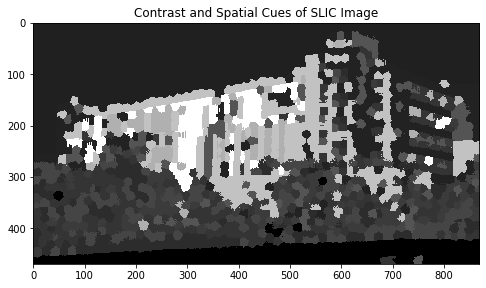

In [13]:
contrast_cues, spatail_cues,clustered_img, final_image = contrast_spatial_cue(slic_image, dict_pixels, label_slic, dict_centers)

### Question 3 
**Implement the separation measure discussed in Sec III.B.1 of the following paper to obtain 
quality scores for the two cues obtained in Q2. Use these quality scores as weights while 
performing the weighted sum of the two cues for getting the final saliency cue. [4 marks]**


In [14]:
def otsu(img):

    min_cost = float('inf')
    threshold = 0

    for i in range(1,256):
        v0 = np.var(img[img < i], ddof = 1)
        w0 = len(img[img < i])
        v1 = np.var(img[img >= i], ddof = 1)
        w1 = len(img[img >= i])

        cost = w0*v0 + w1*v1
        if(cost < min_cost):
            min_cost = cost
            threshold = i

    return threshold

In [15]:
def select_foreground(img):
    m,n = img.shape

    m0 = int(0.15*m)
    n0 = int(0.15*n)
    c0 = 0
    c1 = 0
    for i in range(m//2 - m0, m//2 + m0):
        for j in range(n//2 - n0, n//2 + n0):
            if(img[i,j] == 0):
                c0 = c0 + 1
            else:
                c1 = c1 + 1
    if(c0 > c1):
        return 0
    else :
        return 1

Finding best k: 100%|██████████████████████████████████████████████████████████████████| 51/51 [00:17<00:00,  2.86it/s]


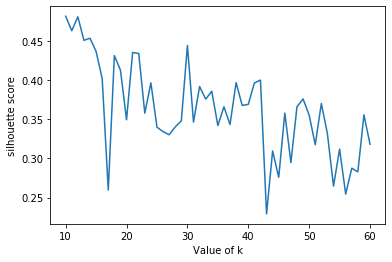

Best Value of k obtained is :  10
Number of Image Pixels per cluster :  {0: 31026, 1: 33715, 2: 28266, 3: 29534, 4: 36727, 5: 54306, 6: 103649, 7: 25724, 8: 32797, 9: 33156}
Contrast Cues :  {0: 0.46911644490149235, 1: 0.5175340822896796, 2: 0.485739882667947, 3: 0.4420607901350514, 4: 0.709606518112828, 5: 0.5836605414966164, 6: 0.6010007815794836, 7: 0.4360955798715506, 8: 0.5024447694370368, 9: 0.49616387851532584}
Spatial Cues :  {0: 0.0007555401139738181, 1: 0.0018625403224607744, 2: 0.0016442214442445441, 3: 0.00040550293161027424, 4: 0.00036229852740717045, 5: 0.0004951680993952326, 6: 0.0003301041662110544, 7: 0.0009196949591165482, 8: 0.0006098782041119718, 9: 0.00022424623897711787}


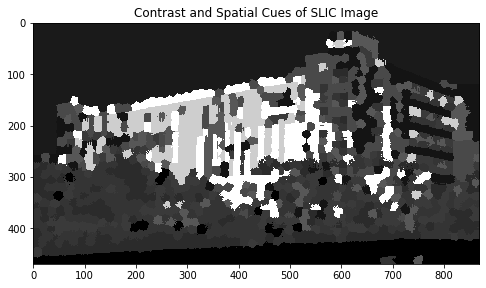

In [16]:
contrast_cues, spatail_cues,clustered_img, final_image = contrast_spatial_cue(slic_image, dict_pixels, label_slic, dict_centers)

In [17]:
s_max = max(list(spatail_cues.values()))
for key in list(spatail_cues.keys()):
    spatail_cues[key] = spatail_cues[key]/s_max

c_max = max(list(contrast_cues.values()))
for key in list(contrast_cues.keys()):
    contrast_cues[key] = contrast_cues[key]/c_max


Text(0.5, 1.0, 'Contrast Cue Image')

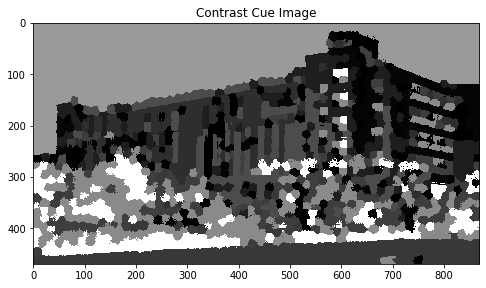

In [18]:
m,n = clustered_img.shape
contrast_cue_image = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        contrast_cue_image[i,j] = contrast_cues[clustered_img[i,j]]
plt.figure(figsize = (8,8))
plt.imshow(contrast_cue_image, cmap = 'gray')
plt.title("Contrast Cue Image")
        

Text(0.5, 1.0, 'Spatial Cue Image')

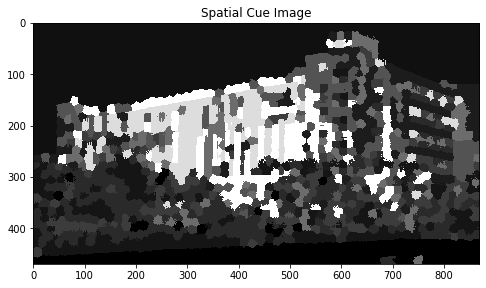

In [19]:
m,n = clustered_img.shape
spatial_cue_image = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        spatial_cue_image[i,j] = spatail_cues[clustered_img[i,j]]
plt.figure(figsize = (8,8))
plt.imshow(spatial_cue_image, cmap = 'gray')
plt.title("Spatial Cue Image")


### Separation  Measure


In [20]:
def gaussian_distribution(x, mu, sigma):
    return (1/(sigma*math.sqrt(2*math.pi)))*np.exp(-(x/sigma - mu/sigma)**2)

In [21]:
def separation_Measure(saliency_map):
    saliency_map = (saliency_map/np.max(saliency_map))*255
    thres = otsu(saliency_map.astype(int))
    print("OTSU Threshold :", thres)
    mask = copy.deepcopy(saliency_map)
    mask[mask < thres] = 0
    mask[mask >= thres] = 1
    fg = select_foreground(mask)
    if(fg == 1):
        foreground_mask = mask
        background_mask = 1 - foreground_mask
    else:
        foreground_mask = 1- mask
        background_mask = 1 - foreground_mask
        
    fig=plt.figure(figsize=(12, 12))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(foreground_mask, cmap = 'gray')
    plt.title("OTSU Foreground Threshold Mask")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(background_mask, cmap = 'gray')
    plt.title("OTSU Background Threshold Mask")
    plt.show()
    
    foreground_map = saliency_map*foreground_mask
    background_map = saliency_map*background_mask
    foreground_map = foreground_map/np.max(foreground_map)
    background_map = background_map/np.max(background_map)
    
    
    fig=plt.figure(figsize=(12, 12))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(foreground_map)
    plt.title(" Foreground  Map")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(background_map)
    plt.title(" Background  Map")
    plt.show()
    
    mu_f = np.mean(foreground_map[foreground_map > 0])
    sigma_f = np.std(foreground_map[foreground_map > 0])
    mu_b = np.mean(background_map[background_map > 0])
    sigma_b = np.std(background_map[background_map > 0])
    print("foreground mean , mu_f : ", mu_f)
    print("background mean , mu_b : ", mu_b)
    print("foreground  standard  deviation , sigma_f : ", sigma_f)
    print("background standard  deviation , sigma_b : ", sigma_b)
    
    fg_vals = foreground_map[foreground_map > 0].flatten()
    bg_vals = background_map[background_map > 0].flatten()
    fg_dist = scipy.stats.norm(mu_f, sigma_f**2).pdf(fg_vals)
    bg_dist = scipy.stats.norm(mu_b, sigma_b**2).pdf(bg_vals)
    
    z_star = (mu_b*sigma_f**2 - mu_f*sigma_b**2)/(sigma_f**2 - sigma_b**2)  +  (sigma_f*sigma_b/(sigma_f**2 - sigma_b**2))*((mu_f - mu_b)**2 - 2*(sigma_f**2 - sigma_b**2)*(math.log(sigma_b) - math.log(sigma_f)))**0.5
    print("z_star : ", z_star)
    L_s = quad(gaussian_distribution, 0, z_star, args=(mu_f,sigma_f))[0] + quad(gaussian_distribution, z_star, 1, args=(mu_b,sigma_b))[0]
    print("L_s : ", L_s)
    
    return L_s


    

For Contrast Cue 
  
OTSU Threshold : 186


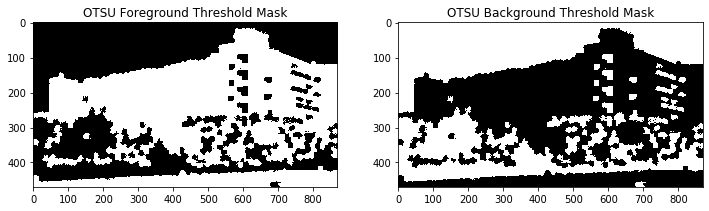

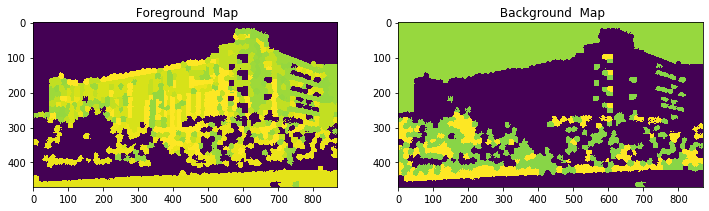

foreground mean , mu_f :  0.9284870871561837
background mean , mu_b :  0.8690060770125418
foreground  standard  deviation , sigma_f :  0.054324487973623894
background standard  deviation , sigma_b :  0.06402446413818173
z_star :  0.8918206778632705
L_s :  0.3359847904207488
For Spatial Cue 
  
OTSU Threshold : 126


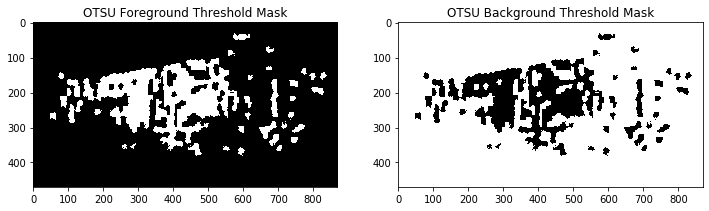

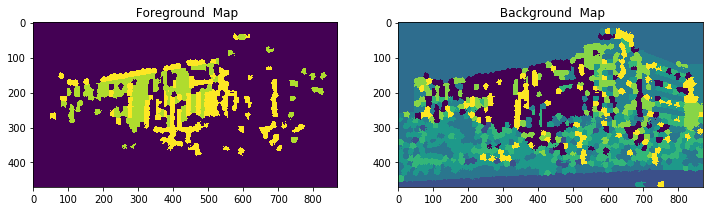

foreground mean , mu_f :  0.9465446246662297
background mean , mu_b :  0.5043719216982213
foreground  standard  deviation , sigma_f :  0.05838090029225169
background standard  deviation , sigma_b :  0.21027560865603862
z_star :  0.818677376095228
L_s :  0.012593715194031598


In [24]:
print('\033[1mFor Contrast Cue \n  \033[0m')
sm_1 = separation_Measure(contrast_cue_image)

print('\033[1mFor Spatial Cue \n  \033[0m')
sm_2 = separation_Measure(spatial_cue_image)

Text(0.5, 1.0, 'Final Saliency Image')

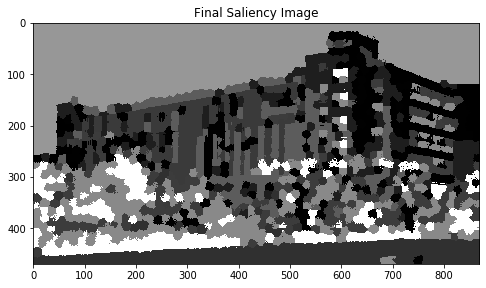

In [25]:
final_saliency_image = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        final_saliency_image[i,j] = sm_1*contrast_cues[clustered_img[i,j]] + sm_2*spatail_cues[clustered_img[i,j]]

plt.figure(figsize = (8,8))
plt.imshow(final_saliency_image, cmap = 'gray')
plt.title("Final Saliency Image")